# Leveraging Machine Learning to Identify Phishing Websites
**Authors:** Ethan Dinh, Izzy Harker, Annika Huston <br>
**Date:** 9 February 2024 <br>
**Class:** CS 433 – Network Security

### Goal
> The primary goal of leveraging machine learning to identify phishing websites is to develop an automated, efficient, and highly accurate system capable of detecting and classifying websites as legitimate or phishing. This system aims to analyze various characteristics of websites, such as URL structure, site content, and metadata, to identify potential phishing attempts. By continuously learning from new data, the model seeks to improve its detection capabilities over time, adapting to the evolving tactics used by cybercriminals.

### Purpose
> The purpose of this initiative is to enhance cybersecurity measures by providing a robust tool that can significantly reduce the risk of phishing attacks for individuals and organizations. By automating the detection of phishing websites, the system intends to preemptively block access to these malicious sites, thereby protecting sensitive information from being compromised. Additionally, this project aims to raise awareness about the sophistication of phishing schemes and promote safer online practices among internet users. Ultimately, leveraging machine learning for phishing website identification supports the broader objective of creating a safer, more secure digital environment for all users.

# Table of Contents
1. [Importing Libraries](#LIBS)
2. [Importing & Cleaning Data Files](#FILTER)
3. [Feature Selection](#FEATURE)
4. [Implementing & Comparing Various Machine Learning Models](#IMPLEMENT)
5. [Hyper Parameter Tuning](#TUNE)
5. [Extrapolation](#EXTRA)

## Importing Core Libraries
<a class="anchor" id="LIBS"></a>

In [8]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

## Importing & Cleaning Data Files
URL: https://www.sciencedirect.com/science/article/pii/S2352340920313202

Overview: 
* These data consist of a collection of legitimate, as well as phishing website instances. Each website is represented by the set of features that denote whether the website is legitimate or not. Data can serve as input for the machine learning process.
* Machine learning and data mining researchers can benefit from these datasets, while also computer security researchers and practitioners. Computer security enthusiasts can find these datasets interesting for building firewalls, intelligent ad blockers, and malware detection systems.
* This dataset can help researchers and practitioners easily build classification models in systems preventing phishing attacks since the presented datasets feature the attributes which can be easily extracted.
* Finally, the provided datasets could also be used as a performance benchmark for developing state-of-the-art machine learning methods for the task of phishing websites classification.

<a class="anchor" id="FILTER"></a>

In [9]:
# Include the file path of the data files here:
filePath = "~/Desktop/CS 433/Final Project/Input Data/"

# Loading in data
df = pd.read_csv(filePath + "dataset_small.csv")

# Remove all null rows
df = df.dropna()

## Feature Selection
<a class="anchor" id="FEATURE"></a>
We will be using recursive feature elimination, or RFE as a feature selection algorithm. RFE is a wrapper-type feature selection algorithm which implies that a different machine learning model will be used to help assist in the feature selection process. In general, RFE works by searching for a subset of features by starting with all features in the training dataset and removing features until the desired number remains. This process is done by fitting the given machine learning model, ranking features by importance, and removing the least important features, and re-fitting the model. 

In [79]:
# Importing the necessary libraries to pick the best features
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from pyHSICLasso import HSICLasso

In [81]:
# Split the data into training and test sets
# Retrieving the features
features = df.columns[:-1]
X = df[features]
Y = df['phishing']

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the dataset
X_scaled = scaler.fit_transform(X)

# Split DF into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, random_state=0, train_size = .75)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(y_train.value_counts())

(43983, 111) (14662, 111)
(43983,) (14662,)
1    22930
0    21053
Name: phishing, dtype: int64


In [104]:
# Adapted from https://machinelearningmastery.com/rfe-feature-selection-in-python/

# Retrieves a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 11):
		rfe = RFE(estimator=LDA(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# Evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    # Use cross_val_predict to get the cross-validated predictions
    y_pred = cross_val_predict(model, X_train, y_train, cv = None, n_jobs = -1, method='predict')
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_train, y_pred)
    
    # You can still calculate scores if you wish to report them alongside the confusion matrix
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores, conf_matrix

In [13]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores, conf_matrix = evaluate_model(model, X_train, y_train)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
	print('Confusion Matrix:\n', conf_matrix)
	print('\n')
	results.append(scores)
	names.append(name)

>2 0.795 (0.003)
Confusion Matrix:
 [[12609  8444]
 [  570 22360]]


>3 0.795 (0.003)
Confusion Matrix:
 [[12609  8444]
 [  559 22371]]


>4 0.795 (0.003)
Confusion Matrix:
 [[12609  8444]
 [  558 22372]]


>5 0.795 (0.003)
Confusion Matrix:
 [[12609  8444]
 [  557 22373]]


>6 0.795 (0.003)
Confusion Matrix:
 [[12609  8444]
 [  556 22374]]


>7 0.795 (0.003)
Confusion Matrix:
 [[12618  8435]
 [  562 22368]]


>8 0.795 (0.003)
Confusion Matrix:
 [[12629  8424]
 [  565 22365]]


>9 0.796 (0.003)
Confusion Matrix:
 [[12630  8423]
 [  565 22365]]


>10 0.796 (0.003)
Confusion Matrix:
 [[12630  8423]
 [  564 22366]]




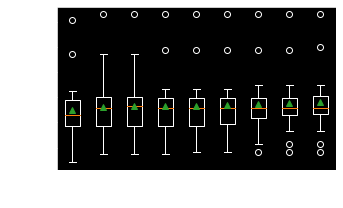

In [14]:
# plot model performance for comparison
fig = plt.figure(figsize = (5, 3))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel("Accuracy")
plt.xlabel("Number of Features") 
plt.style.use('default')
plt.savefig('Model_ACC.png', facecolor='w', transparent=False)

In [33]:
rfe = RFE(estimator=LDA(), n_features_to_select=15)
rfe.fit(X_train, y_train)
col_names = X_train.columns.tolist()

RFE_feats = []
for i in range(X.shape[1]):
	print('Column: %s, Selected %s, Rank: %.3f' % (col_names[i], rfe.support_[i], rfe.ranking_[i]))
	if rfe.support_[i]:
		RFE_feats.append(col_names[i])

Column: qty_slash_url, Selected True, Rank: 1.000
Column: qty_underline_file, Selected True, Rank: 1.000
Column: qty_dot_directory, Selected True, Rank: 1.000
Column: directory_length, Selected True, Rank: 1.000
Column: qty_hyphen_file, Selected True, Rank: 1.000
Column: time_domain_activation, Selected True, Rank: 1.000
Column: qty_comma_file, Selected True, Rank: 1.000
Column: length_url, Selected True, Rank: 1.000
Column: qty_percent_file, Selected True, Rank: 1.000
Column: qty_hyphen_directory, Selected True, Rank: 1.000


In [83]:
# Testing with HSIC Lasso for Feature Selection
hsic_lasso = HSICLasso()
hsic_lasso.input(filePath + "dataset_small.csv", output_list = ["phishing"])
hsic_lasso.classification(10, 5, 2)
hsic_lasso.dump()
hsic_lasso.save_param()

Block HSIC Lasso B = 5.
M set to 2.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
============================================== HSICLasso : Result ==================================================
| Order | Feature      | Score | Top-5 Related Feature (Relatedness Score)                                          |
| 1     | qty_slash_directory | 1.000 | qty_slash_url (0.957), directory_length (0.770), qty_dot_directory (0.702), qty_dot_file (0.694), qty_hyphen_directory (0.687)|
| 2     | qty_underline_file | 0.834 | qty_underline_directory (0.819), qty_tilde_file (0.807), qty_questionmark_directory (0.807), qty_hashtag_directory (0.807), qty_slash_file (0.807)|
| 3     | qty_slash_url | 0.791 | qty_slash_directory (0.957), directory_length (0.798), length_url   (0.652), qty_dot_directory (0.630), qty_dot_file (0.615)|
| 4     | directory_length | 0.775 | qty_slash_url (0.798), qty_slash_directory (0.770), length_url   (0.749), file_length  (0.587), qty_dot_di

In [84]:
HSIC_feats = hsic_lasso.get_features()
print(HSIC_feats)

['qty_slash_directory', 'qty_underline_file', 'qty_slash_url', 'directory_length', 'qty_hyphen_file', 'time_domain_activation', 'qty_dot_file', 'length_url', 'qty_dot_directory', 'qty_dot_domain']


In [85]:
# Comparing the two feature sets
print("RFE Feature Set: ", RFE_feats)
print("HSIC Lasso Feature Set: ", HSIC_feats)

RFE Feature Set:  ['qty_slash_url', 'qty_underline_file', 'qty_dot_directory', 'directory_length', 'qty_hyphen_file', 'time_domain_activation', 'qty_comma_file', 'length_url', 'qty_percent_file', 'qty_hyphen_directory']
HSIC Lasso Feature Set:  ['qty_slash_directory', 'qty_underline_file', 'qty_slash_url', 'directory_length', 'qty_hyphen_file', 'time_domain_activation', 'qty_dot_file', 'length_url', 'qty_dot_directory', 'qty_dot_domain']


## Implementing & Comparing Various Machine Learning Models
<a class="anchor" id="IMPLEMENT"></a>
Defining functions to tune the feature selection algorithm. Each model that is tested will be evaluated via cross-validation to ensure that the results are not due to chance alone.

### Model Selection and Training
Here we will experiment on three different models: Logistic Regression, Decision Tree, and XGBoost

In [128]:
# Splitting the data into training and test sets once again based on results from RFE algorithm
X = df[HSIC_feats]
Y = df["phishing"]

# Split DF into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, random_state=0, train_size = .75)

# Initializing Model Results
model_results = []
model_names = []

In [129]:
LR = LogisticRegression()

# Evaluate the model against the testing data
scores, conf_matrix = evaluate_model(LR, X_train, y_train)
model_results.append(scores)
model_names.append("Logistic Regression")

print(scores.mean())
print(conf_matrix)

/Users/ethandinh/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ethandinh/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

0.9003402266771771
[[18628  2425]
 [ 1953 20977]]


In [130]:
DTC = DecisionTreeClassifier()

scores, conf_matrix = evaluate_model(DTC, X_train, y_train)
model_results.append(scores)
model_names.append("DTC")

print(scores.mean())
print(conf_matrix)

0.927850884300908
[[19468  1585]
 [ 1567 21363]]


In [131]:
# https://www.datacamp.com/tutorial/xgboost-in-python

import xgboost as xgb
xg_classify = xgb.XGBClassifier(verbosity = 0)

scores, conf_matrix = evaluate_model(xg_classify, X_train, y_train)
model_results.append(scores)
model_names.append("XGB")

print(scores.mean())
print(conf_matrix)

0.9543535536328487
[[20027  1026]
 [  970 21960]]


In [133]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()

scores, conf_matrix = evaluate_model(RF, X_train, y_train)
model_results.append(scores)
model_names.append("Random Forest")

print(scores.mean())
print(conf_matrix)

0.9542929019186042
[[19927  1126]
 [  903 22027]]


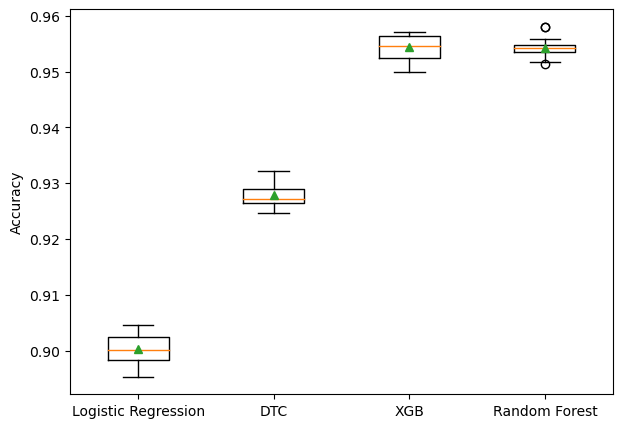

In [134]:
fig = plt.figure(figsize = (7, 5))
plt.boxplot(model_results, labels=model_names, showmeans=True)
plt.ylabel("Accuracy")
plt.style.use('default')
plt.savefig('Model_ACC.png', facecolor='w', transparent=False)

In [109]:
# Train the XGBoost model
xg_classify.fit(X_train, y_train)

# Evaluate the XGBoost model on the test split
xg_score = xg_classify.score(X_test, y_test)
print("XGBoost Accuracy Score:", round(xg_score * 100, 3))

# Train the Random Forest model
RF.fit(X_train, y_train)

# Evaluate the Random Forest model on the test split
rf_score = RF.score(X_test, y_test)
print("Random Forest Accuracy Score:", round(rf_score * 100, 3))

XGBoost Accuracy Score: 0.9560087300504706
Random Forest Accuracy Score: 0.9568953758013914


In [112]:
# Adopted from https://thinkingneuron.com/how-to-tune-hyperparameters-automatically-using-bayesian-optimization/
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, anneal

RF = RandomForestClassifier()
LR = LogisticRegression()
xg_classify = xgb.XGBClassifier()

# Defining a cost function which the Bayesian algorithm will optimize
def RF_objective(parameter_space):
    Error = 1 - cross_val_score(RF, X_train, y_train, cv = 5, scoring='accuracy').mean()
    return {'loss': Error, 'status': STATUS_OK}

def XGB_objective(parameter_space):
    parameter_space = {
        'max_depth': parameter_space['max_depth'],
        'learning_rate': parameter_space['learning_rate'],
        'n_estimators': parameter_space['n_estimators']
    }
    xg_classify = xgb.XGBClassifier(**parameter_space)
    XGB_error = 1 - cross_val_score(xg_classify, X_train, y_train, cv = 5, scoring='accuracy').mean()
    return {'loss': XGB_error, 'status': STATUS_OK}

In [127]:
from sklearn.model_selection import GridSearchCV

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    
    print('\nModel Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 80, 90, 100, 150],
    'max_features': ["sqrt", "log2"],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [5, 8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print("BEST PARAMS:", grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


/Users/ethandinh/miniforge3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x142e72b80>


KeyboardInterrupt: 

In [113]:
RF_parameter_space = { 'n_estimators': hp.quniform('n_estimators',5,50,5),
                       'max_depth': hp.quniform('max_depth',2,10,1),
                       'criterion': hp.choice('criterion', ['gini', 'entropy'])
                    }
  
# Finding out which set of hyperparameters give highest accuracy
RF_trials = Trials()
RF_best_params = fmin(fn= RF_objective,
            space= RF_parameter_space,
            algo=anneal.suggest, 
            max_evals = 100,
            trials= RF_trials)

print(RF_best_params)

 20%|██        | 20/100 [04:24<17:39, 13.25s/trial, best loss: 0.04510829454602927]


KeyboardInterrupt: 

<AxesSubplot:xlabel='criterion'>

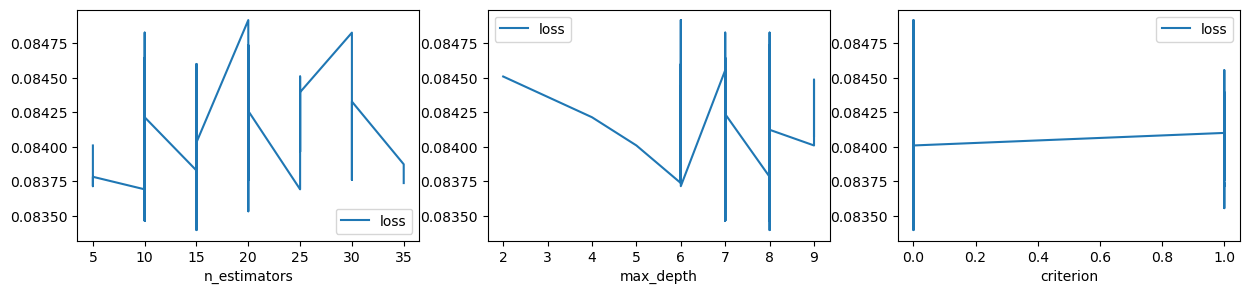

In [28]:
RF_search_results = pd.DataFrame({'loss': RF_trials.losses(), 
                               'n_estimators': RF_trials.vals['n_estimators'],
                               'max_depth': RF_trials.vals['max_depth'],
                               'criterion': RF_trials.vals['criterion']
                               })

fig, subPlots=plt.subplots(nrows=1, ncols=3, figsize=(15,3))
RF_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[0])
RF_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
RF_search_results.sort_values(by='criterion').plot(x='criterion', y='loss', ax=subPlots[2])

We tested the logistic regression model via grid search since the Bayesian Optimization approach seemed to fail.

In [29]:
from sklearn.model_selection import GridSearchCV

space = dict()
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define search
search = GridSearchCV(LR, space, scoring='accuracy', n_jobs=-1, cv=5)

# execute search
LR_result = search.fit(train_x, train_y,)

# summarize result
print('Best Score: %s' % LR_result.best_score_)
print('Best Hyperparameters: %s' % LR_result.best_params_)

/Users/ethandinh/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ethandinh/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best Score: 0.8715640739693651
Best Hyperparameters: {'C': 100}


Text(0, 0.5, 'Accuracy')

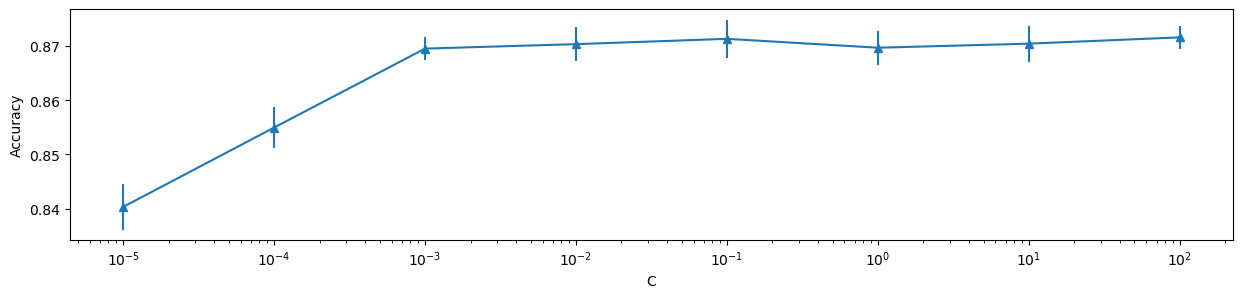

In [30]:
scores = LR_result.cv_results_
means_test = scores["mean_test_score"]
std_test = scores["std_test_score"]
x = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

fig =plt.figure(figsize=(15,3))
plt.errorbar(x, means_test, std_test, marker='^')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")

In [31]:
# Tuning 
XGB_parameter_space = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
    "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
    }

# Finding out which set of hyperparameters give highest accuracy
XGB_trials = Trials()
XGB_best_params = fmin(fn= XGB_objective,
            space= XGB_parameter_space,
            algo=tpe.suggest, 
            max_evals = 100,
            trials= XGB_trials)

print(XGB_best_params)

  1%|          | 1/100 [07:30<12:23:23, 450.54s/trial, best loss: 0.08680614949813115]


KeyboardInterrupt: 

<AxesSubplot:xlabel='n_estimators'>

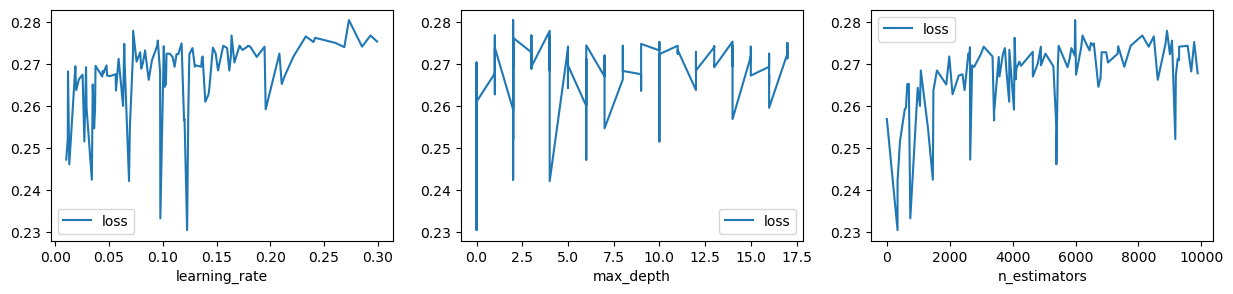

In [ ]:
XGB_search_results = pd.DataFrame({'loss': XGB_trials.losses(), 
                               'learning_rate': XGB_trials.vals['learning_rate'],
                               'max_depth': XGB_trials.vals['max_depth'],
                               "n_estimators": XGB_trials.vals['n_estimators']
                               })

fig , subPlots = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
XGB_search_results.sort_values(by='learning_rate').plot(x='learning_rate', y='loss', ax=subPlots[0])
XGB_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
XGB_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[2])